In [4]:
import sys
sys.path.append('../')

from Análisis.analisis import *

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.
/home/kennorsdb/anaconda3/envs/analysis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kennorsdb/anaconda3/envs/analysis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kennorsdb/anaconda3/envs/analysis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

Loading BokehJS ...

## Clasificación por medio de un Agente de IA

Los documentos que se tienen clasificados solo representan el __18.6%__ de los documentos totales, pero ha significado más de 5 años de trabajo de parte del Centro de Jurisprudencia de la Sala Constitucional. Es por ello que usando las muestras ya clasificadas, se entrenó un modelo de Redes Neuronales Secuencial para estimar cuáles son los temas del resto de documentos.

Para realizar el aprendizaje, se separan los datos en un conjunto que sirvirá para entrenar el agente _(80%, 53268 documentos)_, el resto de resoluciones se utilizan para probar la efectividad de la clasificación. Los resultados demuestran que el __99%__ de las muestras se clasifican correctamente. 

A continuación se presentan la matriz de confusión generada a partir de los datos de prueba.

## Entrenamiento de Términos

In [3]:
data = load_classif_Sala()
labels = data.termino
temp = pd.DataFrame({'tema':labels, 'count':[ 1 for i in labels]}, index=range(len(labels)))
tg = temp.groupby(['tema']).count()
countLabels =  labels.apply(lambda x: tg.loc[x]['count'] )
labels = labels[ countLabels > 6]
corpus, vectorizer, tfidf = vectorizarCorpus(data.cleanText, max_df=0.95, min_df=2, max_features=4000)
corpus_terminos = corpus.todense()[ countLabels > 6]
encoder_termino, labels_termino = encodeLabels(labels)
y_binary_termino = to_categorical(labels_termino)
corpus_scaling, y_binary_termino = dataScaling(corpus_terminos, y_binary_termino)
import os
os.environ['TF_ENABLE_WINOGRAD_NONFUSED'] = '1'
model_termino = NNModel(corpus_scaling.astype('float16'), y_binary_termino)
model_termino.buildModel()
model_termino.fit(verbose=1)
metrics, report = model_termino.test(plotConfusionMatrix=True, encoder=encoder_termino)

### Entrenamiento de Subtemas

/home/kennorsdb/anaconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

The 'contains' method is deprecated and will be removed in a future version. Use 'key in index' instead of 'index.contains(key)'

I0827 11:21:07.451125 140545469212480 analisis.py:274] Separando los datos de entrenamiento y de prueba 
I0827 11:21:07.456888 140545469212480 analisis.py:276] Normalizando los datos
I0827 11:21:07.464530 140545469212480 analisis.py:281] ---> InputLayer: 4000  --  OutputLayer: 4000
I0827 11:21:07.466432 140545469212480 analisis.py:284] Construyecndo el modelo
I0827 11:21:07.550464 140545469212480 analisis.py:297] Iniciando entrenamiento


Epoch 1/5
2331/2331 [==============================] - 1s 444us/step - loss: 0.0663 - acc: 0.9823 - categorical_accuracy: 0.6821 - top_k_categorical_accuracy: 0.8434
Epoch 2/5
2331/2331 [==============================] - 0s 197us/step - loss: 0.0152 - acc: 0.9955 - categorical_accuracy: 0.9245 - top_k_categorical_accuracy: 0.9768
Epoch 3/5
2331/2331 [==============================] - 0s 197us/step - loss: 0.0072 - acc: 0.9975 - categorical_accuracy: 0.9622 - top_k_categorical_accuracy: 0.9957
Epoch 4/5
2331/2331 [==============================] - 0s 212us/step - loss: 0.0044 - acc: 0.9987 - categorical_accuracy: 0.9837 - top_k_categorical_accuracy: 0.9974
Epoch 5/5
2331/2331 [==============================] - 0s 209us/step - loss: 0.0015 - acc: 0.9997 - categorical_accuracy: 0.9949 - top_k_categorical_accuracy: 0.9979


I0827 11:21:10.962283 140545469212480 analisis.py:299] Enrenamiento finalizado
I0827 11:21:10.964437 140545469212480 analisis.py:302] Pruebas de rendimiento: 
I0827 11:21:11.129062 140545469212480 analisis.py:304] Pruebas de rendimiento: Loss: 0.0076764864259196595 Categorical Accuracy:0.9976250072286224
/home/kennorsdb/anaconda3/envs/analysis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



Normalized confusion matrix


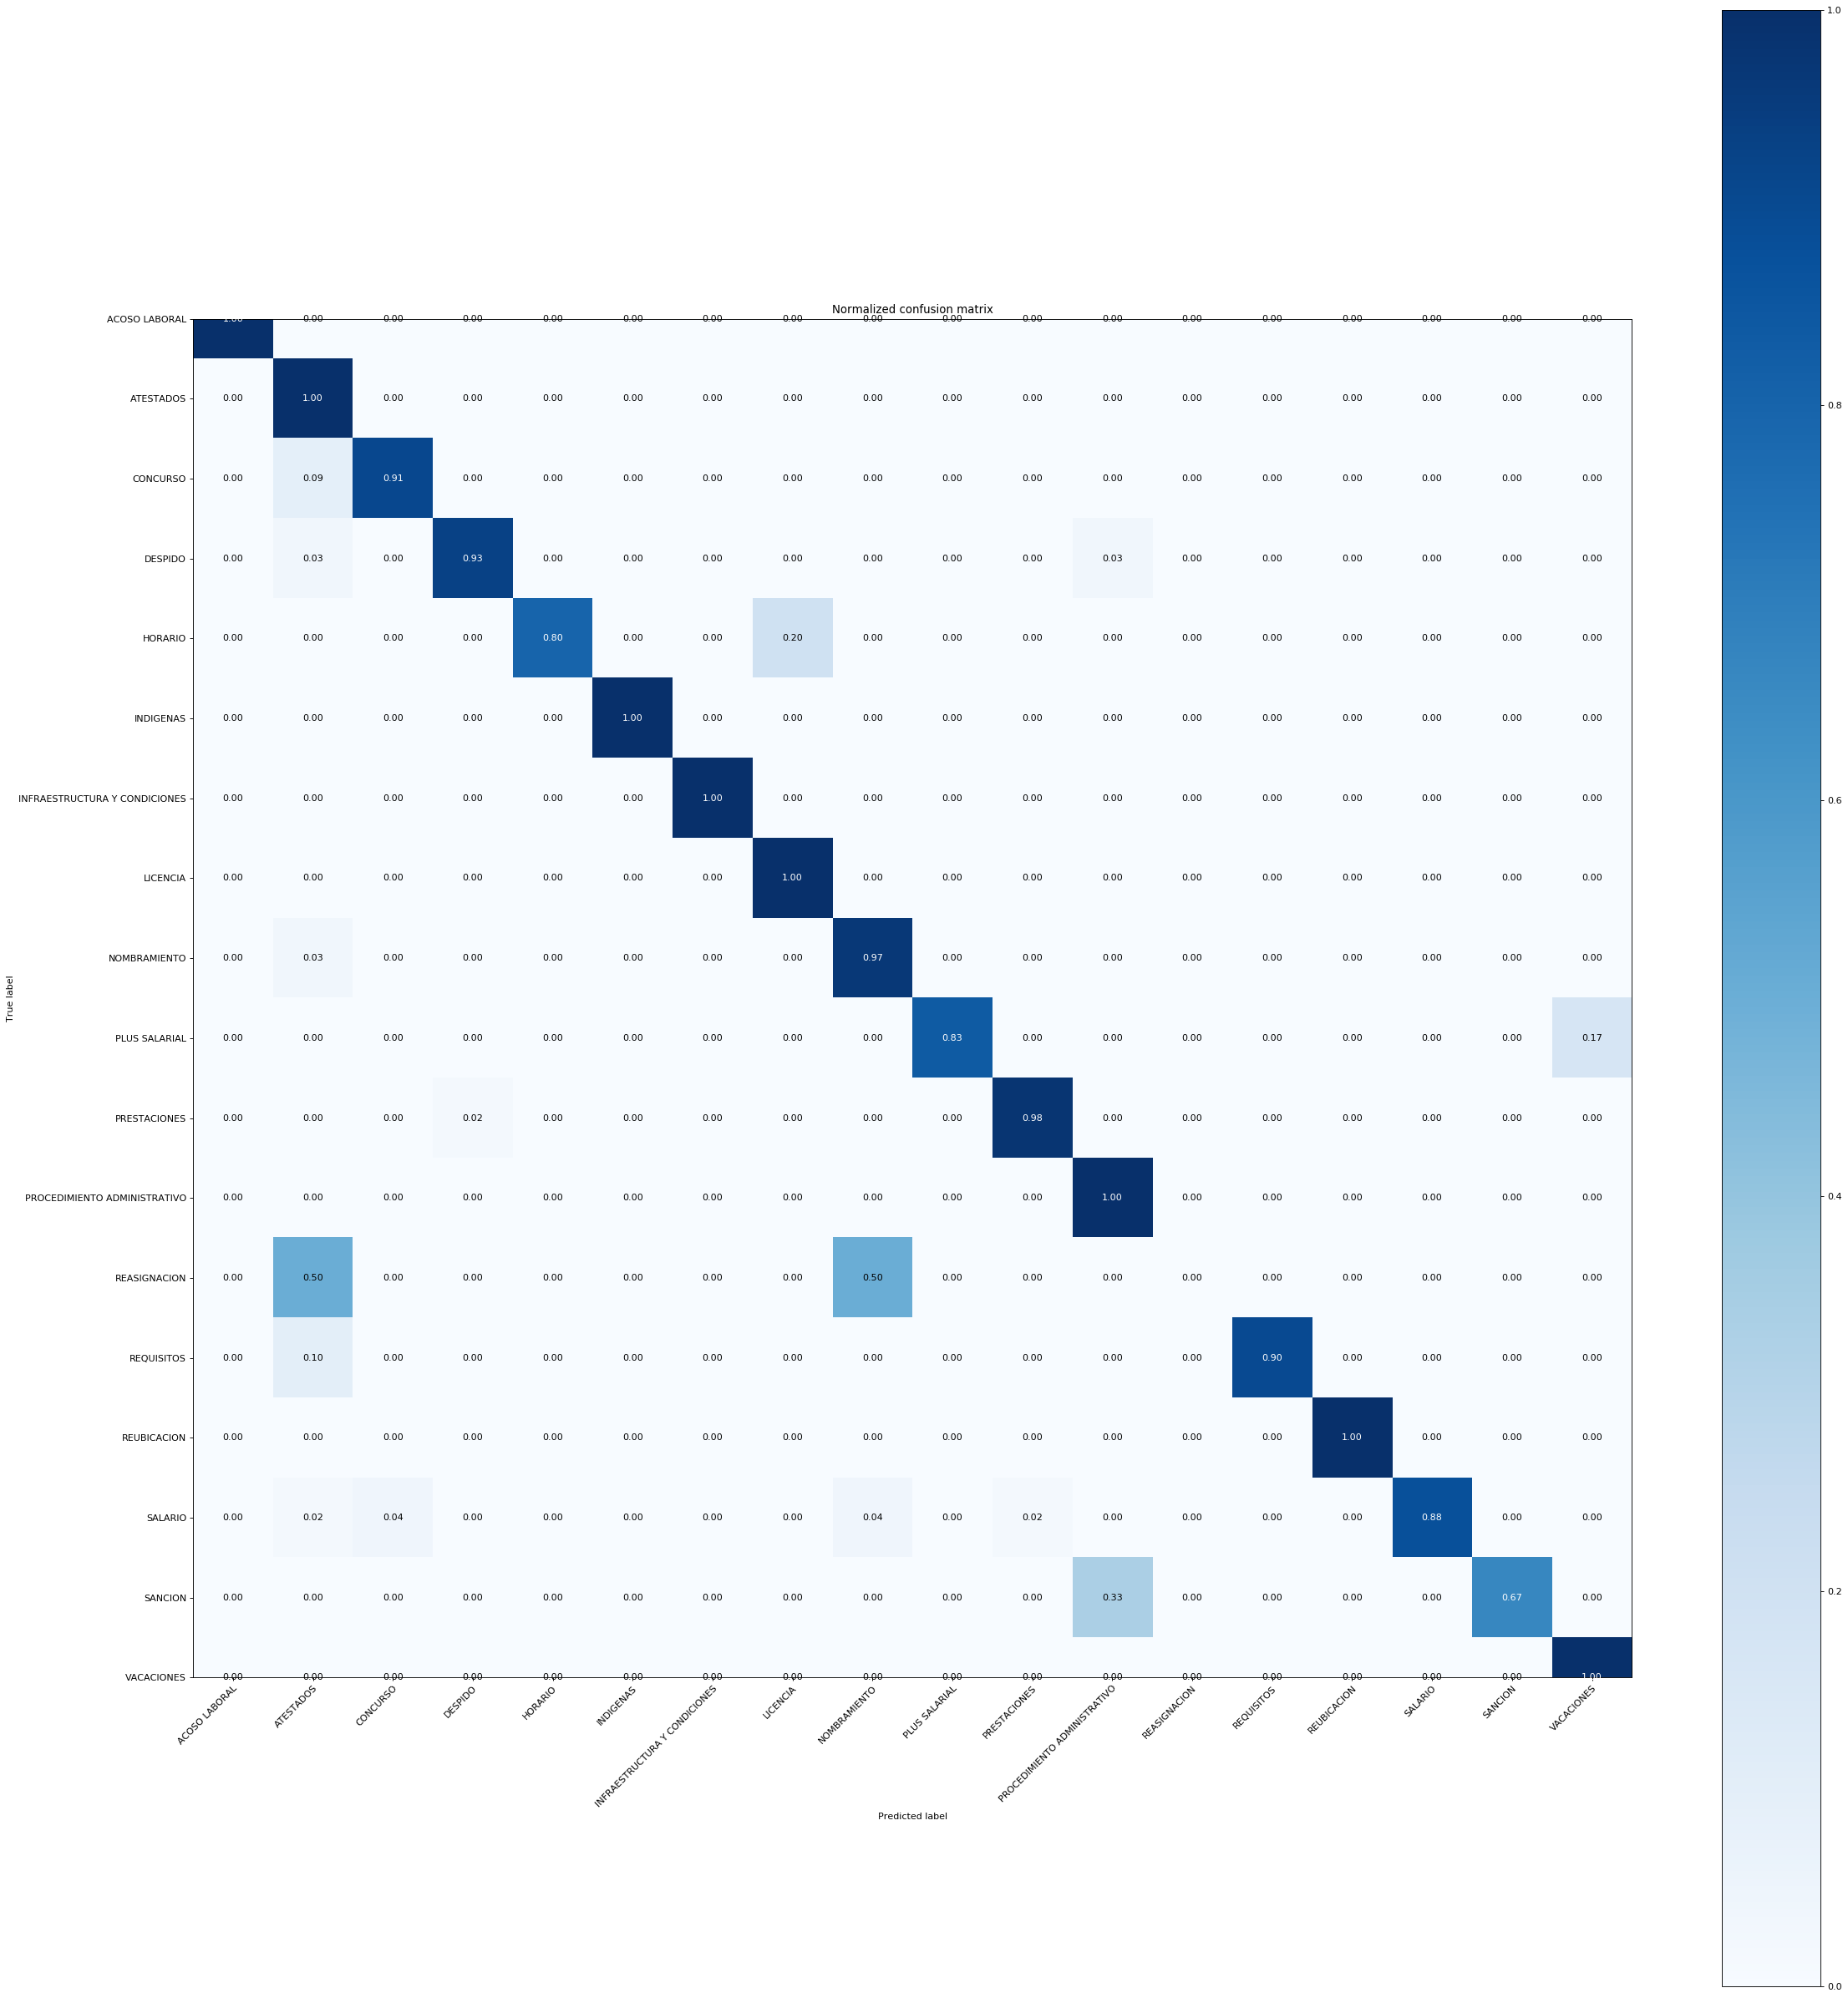

In [56]:
dataSubtema = load_classif_Sala()
dataSubtema = dataSubtema[dataSubtema.tema == 'TRABAJO'][['subtema', 'cleanText']]
labels = dataSubtema.subtema
temp = pd.DataFrame({'subtema':labels, 'count':[ 1 for i in labels]}, index=range(len(labels)))
tg = temp.groupby(['subtema']).sum()
countLabels =  labels.apply(lambda x: tg['count'].loc[x] if tg.index.contains(x) else 0 )
labels = labels[ countLabels >= 6]
corpus, vectorizer, tfidf = vectorizarCorpus(dataSubtema.cleanText, max_df=0.95, min_df=2, max_features=4000)
corpus_subtema = corpus.todense()[ countLabels >= 6]
encoder_subtema, labels_subtema = encodeLabels(labels)
y_binary_subtema = to_categorical(labels_subtema)
corpus_scaling, y_binary_subtema = dataScaling(corpus_subtema, y_binary_subtema)
import os
os.environ['TF_ENABLE_WINOGRAD_NONFUSED'] = '1'
model_termino = NNModel(corpus_scaling.astype('float16'), y_binary_subtema)
model_termino.buildModel()
model_termino.fit(verbose=1)
metrics, report = model_termino.test(plotConfusionMatrix=True, encoder=encoder_subtema)

In [60]:
noTags_data = AllCorpus(model_termino.get_model(), encoder_subtema, vectorizer, tfidf)

In [61]:
noTags_data.predict()